In [1]:
%matplotlib notebook

In [2]:
from neuron import h , gui
from neuron.units import ms , mV
import matplotlib.pyplot as plt
import numpy as np
#We'll load the standard run library to give us high-level simulation control functions 
#(e.g. running a simulation for a given period of time):
h.load_file('stdrun.hoc')

1.0

# Parametros universais do programa

In [3]:
r_axial_extracell = [161.8, 1000000000] #M$\ohm$/cm
c_extracell = [0, 0] #F/cm2
g_extracell = [1, 1000000000] #S/cm2 
e_extracell = 0 #mV

In [4]:
class Cell:
    #é nessa função q está a necessidade de parametros externos a serem passados
    def __init__(self, gid, x, y, z, theta):
        self._gid = gid
        self._morphology()
        self.all = self.soma.wholetree() #Is this a buit in function?
        self._biophysics()
        self.x = self.y = self.z = 0
        h.define_shape()
        self._rotate_z(theta)
        self._set_position(x, y, z)
        
    def _set_position(self, x, y, z):
        for sec in self.all:
            for iseg in range(sec.n3d()): ####não entendi o funcionamento da função
                sec.pt3dchange(iseg,
                               x - self.x + sec.x3d(iseg),
                               y - self.y + sec.y3d(iseg),
                               z - self.z + sec.z3d(iseg),
                               sec.diam3d(iseg))
        self.x, self.y, self.z = x, y, z
        
    def _rotate_z(self, theta): ####nem dessa
        """Rotate the cell about the Z axis."""
        for sec in self.all:
            for i in range(sec.n3d()):
                x = sec.x3d(i)
                y = sec.y3d(i)
                c = h.cos(theta)
                s = h.sin(theta)
                xprime = x * c - y * s
                yprime = x * s + y * c
                sec.pt3dchange(i, xprime, yprime, sec.z3d(i), sec.diam3d(i))
        
    #pq vc não funcionaaaaaaaaaa? era pra colocar o nome bonitinho quando digita topology
    def __repr__(self):
        return '{}[{}]'.format(self.name, self._gid) 

In [5]:
class ToyCellY(Cell):
    #construir as partes da celula tipo soma dends e axons
    #é nessa função q está a necessidade de parametros externos a serem passados
    
    Cell.name = 'ToyCellY'
        
    def _morphology(self):
        self.soma = h.Section(name="soma")
        self.dend = h.Section(name="dend")
        self.passives = [self.dend]
        
        self.dend.nseg = 3
        
        self.nsegtotal = self.dend.nseg + self.soma.nseg
        
        ####morfologias especiais###
        #gid impares tem um dend a mais
#         if self._gid % 2 != 0: #tem como fazer isso de outra forma no meio do codigo
#             self.dend1 = h.Section(name='dend1')
#             self.passives.append(self.dend1)
#             self.dend1.L = self.soma.L * 2 #60 micrometers
#             self.dend1.diam = 1
#             self.dend1.connect(self.dend(0.5))
        ###_______________________###
        self.dend.connect(self.soma)
        
        #intrinsic characterisics of the system
        self.soma.L = self.soma.diam = 30 #micrometers
        self.dend.L = self.soma.L * 2 #60 micrometers
        self.dend.diam = 1
        
        self.comprimento = self.dend.L + self.soma.L
    
    def _biophysics(self):
        #active mechanisms 
        self.soma.insert('hh')
#         for segSoma in self.soma:
#             segSoma.hh.el = -60 #de que ion é esse potencial reverso
#             segSoma.hh.gnabar = 0.2
#             segSoma.hh.gkbar = 0.001
        
        #passive mechanisms
        for passivos in self.passives:
            passivos.insert('pas')
#             for segPassivos in passivos:
#                 segPassivos.pas.e = -70 #de que ion é esse potencial reverso
#                 segPassivos.pas.g = 0.01 # na real issos são listas

        #insert extracellular mechanhisms
        for sec in self.all:
            sec.insert('extracellular')
            for segmento in sec:
                segmento.xraxial[0] = 0.01*(self.dend.Ra) #\cite{Appukutan2017}
                segmento.xg[0] = g_extracell[0]
                segmento.xc[0] = c_extracell[0]
                segmento.xraxial[1] = r_axial_extracell[0]
                                

# Construção do sincitio e celulas
## Construção 1
Cria um sincicio numa diagonal com espaços entre as celulas aumentando conforme seu indice(?)

## Construção 2
Celulas somente no plano yz em forma quadrada com espaço de 1 entre elas. Estão na forma:
$$\begin{bmatrix}
[2] & [3] \\
[0] & [1] 
\end{bmatrix}$$

In [6]:
celulas = []

#ToyCellY(gid, x, y, z, theta)

#CONSTRUÇÃO 1
#for gid in range(4):
#    celulas.append(ToyCellY(gid, 0, (gid*celulas[0].comprimento)+gid, (gid*celulas[0].soma.diam)+gid, 0))
    
#isso aqui vai dar um quadrado de celulas    
celulas.append(ToyCellY(0, 0,   0,    0, 0))
celulas.append(ToyCellY(1, 0, 100, -100, 0))
celulas.append(ToyCellY(2, 0,   0, -100, 0)) 
celulas.append(ToyCellY(3, 0, 100, -200, 0)) 


<IPython.core.display.Javascript object>


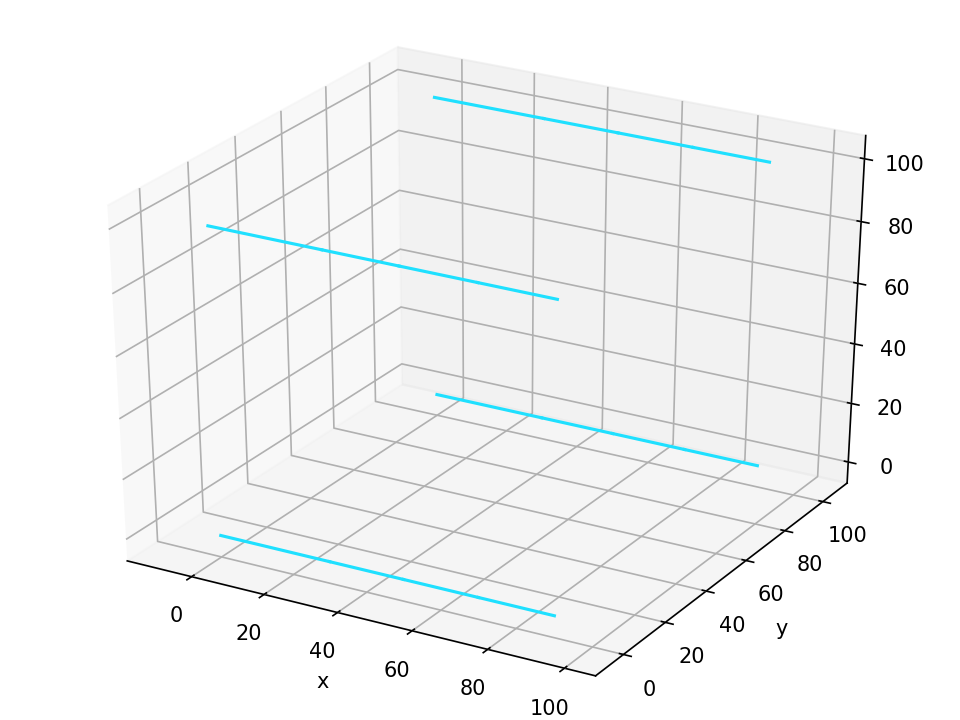

Text(0.5, 0, 'y')

In [7]:
#to plot the cell that we created we do

h.PlotShape(False).plot(plt)
plt.xlabel('x')
plt.ylabel('y')
#plt.zlabel('z')

# Meio extracellular
Tem bugs diversos, a documentação fala isso. cuidado a aplicar
## conexões 
utilizaremos o linear mechanisms pra tentar conectar dois compartmentos ajacentes
### modo de uso:
implementa a diff equation matricial in the form of:
$$c \frac{dy}{dt} + g y = b $$
iremos setar uma conexão transversal entre 2 section (discretized over segments)

|---| <> |---|

cell1 <> cell2

In [21]:
# internal_conect = [0, 0, 0, 0]

# #linking internally soma with dends of cells
# for i in range(len(celulas)):
#     r_link = r_axial_extracell[0] * celulas[i].dend.L / celulas[i].dend.nseg # resistivity of the link
#     g_e = 1 / (2 * h.PI * (celulas[i].dend.diam/2) * r_link) # condutancia extracell do link

#     c = h.Matrix(2, 2) #(nroll,ncoll)
#     g = h.Matrix(2, 2)
#     y = h.Vector(2) #(lengnth)
#     b = h.Vector(2)

#     g.setval(1, 1,  g_e)
#     g.setval(1, 0, -g_e)
#     g.setval(0, 1, -g_e)
#     g.setval(0, 0,  g_e)

#     y[0] = celulas[i].soma(1).vext[0] #potencial extracellular em volt
#     y[1] = celulas[i].dend(0).vext[0] 

#     # y0 = h.Vector(2) #condição inicial da eq diff 
#     # DEU RUIM

#     internal_conect[i] = h.LinearMechanism(c, g, y, b)
#     # lm = h.LinearMechanism(c, g, y, [y0], b, sl, xvec, [layervec])

NEURON: Couldn't create sparse matrix
 near line 0
 ^
        doNotify()


Exception in gui thread


Estou ligando na vertical e na horizontal os dendritos que ACHO que estão paralelos 

estou conecting the cell 0 with cell 1 and cell 2 from 0->1 0->2 1->0 2->0

FALTA: 0->3 1->2 2->1 3->0 diagonais

   3->1 3->2 1->3 2->3 cantos

In [22]:
r_link = r_axial_extracell[0] * celulas[0].dend.L / celulas[0].dend.nseg # resistivity of the link
g_e = 1 / (2 * h.PI * (celulas[0].dend.diam/2) * r_link) # condutancia extracell do link

c = h.Matrix(9, 9) #(nroll,ncoll)
g = h.Matrix(9, 9)
y = h.Vector(9) #(lengnth)
b = h.Vector(9)

###construção da matriz g do \cite{appukuttan2017}
for i in range(3): #faz as tras primeiras linhas da matriz
    g.setval(i, i  ,  g_e)
    g.setval(i, i+3, -g_e)
    
for i in range(3): #faz as linhas do meio
    g.setval(3+i,   i,  -g_e)
    g.setval(3+i, 3+i, 2*g_e)
    g.setval(3+i, 6+i,  -g_e)

for i  in range(3): #aqui faz as ultimas linhas
    g.setval(6+i, 3+i, -g_e)
    g.setval(6+i, 6+i,  g_e)
    
y[0] = celulas[0].dend(0).vext[0] #potencial extracellular em volt
y[1] = celulas[0].dend(0.5).vext[0]
y[2] = celulas[0].dend(1).vext[0]
y[3] = celulas[1].dend(0).vext[0] #potencial extracellular em volt
y[4] = celulas[1].dend(0.5).vext[0]
y[5] = celulas[1].dend(1).vext[0]
y[6] = celulas[2].dend(0).vext[0] #potencial extracellular em volt
y[7] = celulas[2].dend(0.5).vext[0]
y[8] = celulas[2].dend(1).vext[0]

external_conect = h.LinearMechanism(c, g, y, b)

# Falar na reunião
Assim to achando que tem que fazer uma media do r_link entre as seções proximas

100% perdido pra escolher os parametros que vou usar pra fazer as cotas

In [10]:
#cellAbove.dend.n3d
# for i in celulas :
#     print(i)
#     print(Cell.s)
    
#celulas[0].soma(0.5).diam3d

In [11]:
#ps = h.PlotShape(True)
#ps.show(0)
h.topology()


|-|       soma(0-1)
   `--|       dend(0-1)
|-|       soma(0-1)
   `--|       dend(0-1)
|-|       soma(0-1)
   `--|       dend(0-1)
|-|       soma(0-1)
   `--|       dend(0-1)



1.0

In [12]:
celulas[0].dend.psection()

{'point_processes': {},
 'density_mechs': {'pas': {'g': [0.001, 0.001, 0.001],
   'e': [-70.0, -70.0, -70.0],
   'i': [0.0, 0.0, 0.0]},
  'extracellular': {'xraxial': [[0.354, 161.8],
    [0.354, 161.8],
    [0.354, 161.8]],
   'xg': [[1.0, 1000000000.0], [1.0, 1000000000.0], [1.0, 1000000000.0]],
   'xc': [[0.0, 0.0], [0.0, 0.0], [0.0, 0.0]],
   'e': [0.0, 0.0, 0.0],
   'i_membrane': [0.0, 0.0, 0.0],
   'vext': [[0.0, 0.0], [0.0, 0.0], [0.0, 0.0]]}},
 'ions': {},
 'morphology': {'L': 60.0,
  'diam': [1.0, 1.0, 1.0],
  'pts3d': [(30.0, 0.0, 0.0, 1.0),
   (40.0, 0.0, 0.0, 1.0),
   (60.0, 0.0, 0.0, 1.0),
   (80.0, 0.0, 0.0, 1.0),
   (90.0, 0.0, 0.0, 1.0)],
  'parent': soma(1),
  'trueparent': soma(1)},
 'nseg': 3,
 'Ra': 35.4,
 'cm': [1.0, 1.0, 1.0],
 'regions': set(),
 'species': set(),
 'name': 'dend',
 'hoc_internal_name': '__nrnsec_000002357204a890',
 'cell': None}

# Hora das sinapses
Primeiro precisamos criar um estimulador para a rede de neuronio, esse é o `NetStim()`. Tem os argumentos `interval` que é sobre o inervalo entre spikes/estimulos em ms, `number` que indica o numero de spikes q vao ser fornecidos, `start` é o tempo em ms que vai começar os spikes e `noise` que indica quanto ruido vai ter no seu estimulo (0 - 1).

Depois precisamos fazer q uma synapse ocorra, por meio do `ExpSyn(section(x))` que tem `tau`, a constante de decaimento temporal em ms, `e` o potencial reverso mV ????? e `i` que é a corrente sinaptica ?????. `i` obedece a equação: (weight é dado pelo `NetCon`) aparentemente o `ExpSyn` é colocado no destino da NetCon
$$ i = G * (v - e)  $$
$$G = weight * exp(\frac{-t}{tau})$$

Agora so falta ligar duas celulas juntinhas pra elas serem feliz, com `NetCon(source._ref_v, target, [threshold, delay, weight], sec=section))` `NetCon(source, target, [threshold, delay, weight])` (network connection). "Network Connection object that defines a synaptic connection between a source and target. When the source variable passes threshold in the positive direction at time t-delay, the target will receive an event at time t along with weight information." [threshold, delay, weight] = [10, 0 1] by default. *Tem mais coisas mas não estou enntendendoooo*

perguntas:

1. The source and the target construction of NetCon allows information from the target affects the source characteristics, such as $V_m$? If not, how can I do it without bugs?

2. O ExpSyn pode ser considerado uma axonio virual? 

3. Tem como criar uma ligação passiva, no sentido de ser como um dendrito,entre duas celulas?

## Config. stimulator

### Configuring IClamp for stimulation

In [13]:
stimulation = h.IClamp(celulas[0].dend(1))
#nameOfStim = putIClamp in object with segment and (position)
#Proprieties of stimulation
stimulation.delay = 10 #mili seconds
stimulation.dur = 5 #mili seconds
stimulation.amp = 0.1 #nano Àmpere

### Cunfiguring NetStim for simulation

In [14]:
# stim = h.NetStim() # Make a new stimulator 

# # Attach it to a synapse in the middle of the dendrite
# # of the first cell in the network. (Named 'syn_' to avoid
# # being overwritten with the 'syn' var assigned later.)

# syn_ = h.ExpSyn(celulas[0].dend(1)) #synapse with discontinous conductance

# stim.number = 2 #number of spikes
# stim.start = 3 #NetStim will start at t=3
# ncstim = h.NetCon(stim, syn_)
# ncstim.delay = 1 * ms #after a 1 ms delay it will produce a spike
# ncstim.weight[0] = 0.0004 # NetCon weight is a vector.

# syn_.tau = 0.01 * ms

In [15]:
# print(syn_.tau)

## Config. network connections

Estamos conectando somente o soma da celulas[0] no dend da celulas[1]

In [16]:
syns = []
netcons = []
syn = [0,0,0,0]
nc = [0,0,0,0]

for i in range(len(celulas)):
    
    for j in range(len(celulas)): 
        if i != j:
            syn= h.ExpSyn(celulas[j].dend(1))
            nc = h.NetCon(celulas[i].soma(0)._ref_v, syn, sec = celulas[i].soma) 
            nc.weight[0] = 0.1
            nc.delay = 10 * ms 
            netcons.append(nc)
            syns.append(syn)



# for j in range(len(celulas)): 
#     if i != j:
#         print(j)
#         syn= h.ExpSyn(celulas[2].dend(1))
#         nc = h.NetCon(celulas[1].soma(0)._ref_v, syn, sec = celulas[0].soma) 
#         nc.weight[0] = 0.1
#         nc.delay = 10 * ms 
#         netcons.append(nc)
#         syns.append(syn)


In [17]:
print(netcons)

[NetCon[0], NetCon[1], NetCon[2], NetCon[3], NetCon[4], NetCon[5], NetCon[6], NetCon[7], NetCon[8], NetCon[9], NetCon[10], NetCon[11]]


# Experiments in syncytium

# Graficos

In [18]:
dend_v = [0, 0, 0, 0]
soma_v = [0, 0, 0, 0]

dend_v[0] = h.Vector().record(celulas[0].dend(1)._ref_v)
soma_v[0] = h.Vector().record(celulas[0].soma(1)._ref_v)
time = h.Vector().record(h._ref_t)

dend_v[1] = h.Vector().record(celulas[1].dend(1)._ref_v)
soma_v[1] = h.Vector().record(celulas[1].soma(1)._ref_v)
# dend1_v = h.Vector().record(celulas[1].dend1(1)._ref_v)

dend_v[2] = h.Vector().record(celulas[2].dend(1)._ref_v)
soma_v[2] = h.Vector().record(celulas[2].soma(1)._ref_v)

dend_v[3] = h.Vector().record(celulas[3].dend(1)._ref_v)
soma_v[3] = h.Vector().record(celulas[3].soma(1)._ref_v)

h.finitialize(-60 * mV)
h.continuerun(100 * ms)

0.0

<IPython.core.display.Javascript object>


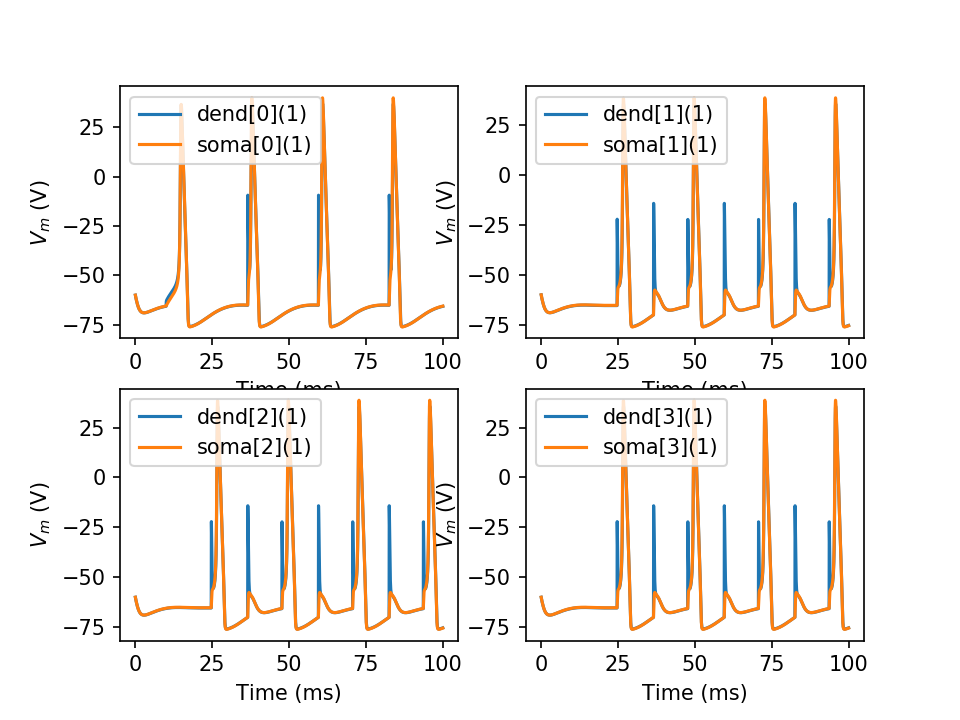

In [19]:
plt.figure()
plt.subplot(2, 2, 1)
plt.plot(time, dend_v[0], label='dend[0](1)')
plt.plot(time, soma_v[0], label='soma[0](1)')
plt.ylabel('$V_m$ (V)')
plt.xlabel('Time (ms)')
plt.legend()
plt.show()

# plt.figure()
plt.subplot(2, 2, 2)
# plt.plot(time, dend1_v, label='dend1[1](1))')
plt.plot(time, dend_v[1], label='dend[1](1)')
plt.plot(time, soma_v[1], label='soma[1](1)')
plt.ylabel('$V_m$ (V)')
plt.xlabel('Time (ms)')
plt.legend()
plt.show()

# plt.figure()
plt.subplot(2, 2, 3)
plt.plot(time, dend_v[2], label='dend[2](1)')
plt.plot(time, soma_v[2], label='soma[2](1)')
plt.ylabel('$V_m$ (V)')
plt.xlabel('Time (ms)')
plt.legend()
plt.show()

# plt.figure()
plt.subplot(2, 2, 4)
plt.plot(time, dend_v[3], label='dend[3](1)')
plt.plot(time, soma_v[3], label='soma[3](1)')
plt.ylabel('$V_m$ (V)')
plt.xlabel('Time (ms)')
plt.legend()
plt.show()




In [20]:
# celulas[0].dend.Ra
